# Custom Single-Qubit Delay Error Simulator Backend
#### Ethan Dickey, Qiskit Demoday and Roadmap meeting, Aug 5, 2021
This notebook adds a customized `DelayAerSimulator` backend that extends the `AerSimulator` to support simulation of parameterized delay noise in scheduled circuits.

## Motivation

- Ability to schedule circuits
  - Adds delay gates
- Accurate noisy simulations
- Current noise model doesn't consider parameters

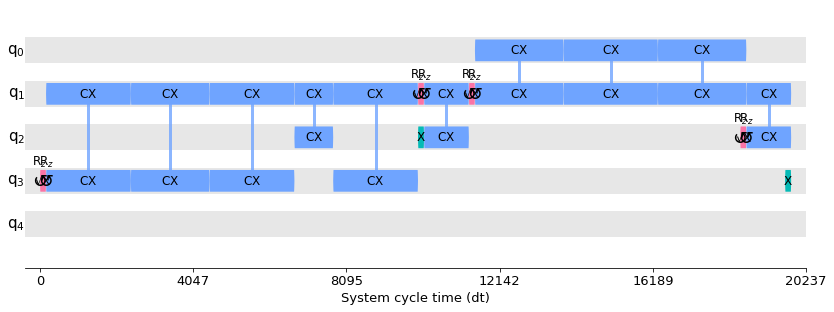

In [1]:
from qiskit.visualization.timeline import draw
from qiskit import QuantumCircuit, transpile
from qiskit.test.mock import FakeVigo

# Simulator backend
_delay_ex_backend = FakeVigo()

# Make a cirucit
_qc = QuantumCircuit(4)
_qc.h(0)
_qc.cx(0, 1)
_qc.x(1)
_qc.cx(0, 2)
_qc.x(2)
_qc.cz(1, 0)
_qc.h(1)
_qc.cx(1, 3)

# Schedule
_sched_circ = transpile(_qc, _delay_ex_backend, scheduling_method='alap')
draw(_sched_circ)

In [2]:
_sched_circ.draw(fold=-1)

┌──────────────────┐                                                                                                                                                                        ┌───┐     ┌─────────────────┐
      q_3 -> 0 ┤ DELAY(11488[dt]) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────┤ X ├──■──┤ DELAY(1184[dt]) ├
               └┬────────────────┬┘                      ┌───┐                                                    ┌─────────┐    ┌────┐┌─────────┐┌───┐    ┌─────────┐       ┌────┐  ┌─────────┐   ┌─┴─┐   └─┬─┘┌─┴─┐└──────┬───┬──────┘
      q_2 -> 1 ─┤ DELAY(160[dt]) ├────────────────────■──┤ X ├──■───────────■──────────────────────────────■──────┤ RZ(π/2) ├────┤ √X ├┤ RZ(π/2) ├┤ X ├────┤ RZ(π/2) ├───────┤ √X ├──┤ RZ(π/2) ├───┤ X ├─────■──┤ X ├───────┤ X ├───────
               ┌┴────────────────┤                    │  └─┬─┘  │         ┌─┴─┐       ┌─────────────────┐  │      └──┬───┬──┘    └────┘└─────────┘└─┬─┘┌───┴─────────┴───┐┌──┴────┴─┐└──┬────┬─┘┌──┴───┴──┐     └───┘       └─┬─┘       
      q_1 -> 2 ┤ DELAY(6720[dt]) ├────────────────────┼────┼────┼─────────┤ X ├───────┤ DELAY(2240[dt]) ├──┼─────────┤ X ├──────────────────────────■──┤ DELAY(7168[dt]) ├┤ RZ(π/2) ├───┤ √X ├──┤ RZ(π/2) ├───────────────────■─────────
               └───┬─────────┬───┘ ┌────┐┌─────────┐┌─┴─┐  │  ┌─┴─┐┌──────┴───┴──────┐└─────────────────┘┌─┴─┐┌──────┴───┴──────┐┌───┐                 └─────────────────┘└─────────┘   └────┘  └─────────┘                             
      q_0 -> 3 ────┤ RZ(π/2) ├─────┤ √X ├┤ RZ(π/2) ├┤ X ├──■──┤ X ├┤ DELAY(1024[dt]) ├───────────────────┤ X ├┤ DELAY(9696[dt]) ├┤ X ├──────────────────────────────────────────────────────────────────────────────────────────────────
               ┌───┴─────────┴────┐└────┘└─────────┘└───┘     └───┘└─────────────────┘                   └───┘└─────────────────┘└───┘                                                                                                  
ancilla_0 -> 4 ┤ DELAY(19840[dt]) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               └──────────────────┘

## Implementation

- Hacked backend adds a transpilation pass which modifies the noise model
- Option to turn it off

In [3]:
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.backends.aerbackend import AerBackend
from qiskit.providers.aer.noise import NoiseModel, thermal_relaxation_error
from qiskit.transpiler import PassManager
import copy
from qiskit import QuantumCircuit
from delayPasses.delayRelaxationPass import DelayReplace

class DelayAerSimulator(AerSimulator):
    #Define the noise model (to post-process the replaced delay gates into actual noise)
    def thermal_relaxation_function(self):
        """Return function for generating thermal relaxation errors.

        The returned function is used to generate thermal relaxation
        errors for delay instructions based on the qubit `T1`, `T2`
        properties, and `dt` time of the provided backend.

        Args:
            backend (Backend): A backend object.

        Returns:
            Callable: the delay error function with signature
                      ``fn(qubits, params) -> QuantumError```.
        """
        properties = self.properties()
        dt = self.configuration().dt


        def delay_error(qubits, params):
            """Return error instruction for delay on specified qubits.

            Args:
                qubits (List[int]): qubits to apply delay to.
                duration (List[float]): length one list of delay
                    duration param. The delay time is given by
                    ``params[0] * dt``.

            Returns:
                QuantumError: the error instruction.
            """
            time = params[0] * dt
            error = None
            for qubit in qubits:
                t1 = properties.t1(qubit)
                t2 = properties.t2(qubit)
                qubit_error = thermal_relaxation_error(t1, t2, time)
                if error is None:
                    error = qubit_error
                else:
                    error = error.expand(qubit_error)
            return error

        return delay_error
    
    def add_transpiler_parameterized_errors(self, circuits, noise_model=None):
        """Extracts the parameterized errors from each circuit's metadata and
            adds them to the noise model given.  Circuit should
            have been transpiled with the delay pass included for this to
            be useful.  Errors are characterized by which backend simulator
            is provided (currently only AerBackends are supported).

        Args:
            backend (Backend): An AerBackend instance to add the noise
                error to.
            circuits (QuantumCircuit(s)): Quantum circuits with metadata including
                the transpiler_parameterized_error field.
            noise_model: Noise model to use or else one is generated.

        Returns:
            None
        """

        # Look for existing noise model
        # Make a copy of noise model since we are appending it
        nm = copy.deepcopy(noise_model) or NoiseModel()


        #retrieve function to generate errors based on backend
        backend_delay_error = self.thermal_relaxation_function()

        if isinstance(circuits, QuantumCircuit):
            circuits = [circuits]

        for circuit in circuits:
            #Validate metadata
            if not circuit.metadata or 'transpiler_parameterized_error' not in circuit.metadata:
                print("Warning: One circuit does not have any parameterized errors")
                continue

            metadata = circuit.metadata.pop('transpiler_parameterized_error')
            qubit_indices = {qubit: idx for idx, qubit in enumerate(circuit.qubits)}

            #Add delay errors to noise model
            #  transpile_paramaterized_errors = {tuple(labelstring, qubitlist): paramlist: [float]}
            for (label, qubits), params in metadata.items():
                qargs = [qubit_indices[i] for i in qubits]
                #todo:: check if we can change qubitlist to be the indicies like done ^^
                error = backend_delay_error(qargs, params)

                # Add to noise model(QuantumError, label: String, [qubits])
                nm.add_quantum_error(error, label, qargs)
        return nm
    
    # Override methods of AerSimulator to add support for automatically
    # extending the noise model with errors for the parameterized gates

    @classmethod
    def _default_options(cls):
        # Add delay option defaulting to false
        opts = AerSimulator._default_options()
        opts.delay_noise = False
        return opts

    @classmethod
    def from_backend(cls, backend, **options):
        """Initialize simulator from backend."""

        # Add delay noise option
        if 'delay_noise' not in options:
            options['delay_noise'] = True

        # Get configuration and properties from backend
        configuration = copy.copy(backend.configuration())
        properties = copy.copy(backend.properties())

        # Customize configuration name
        name = configuration.backend_name
        configuration.backend_name = 'aer_simulator({})'.format(name)

        # Use automatic noise model if none is provided
        if 'noise_model' not in options:
            noise_model = NoiseModel.from_backend(backend)
            if not noise_model.is_ideal():
                options['noise_model'] = noise_model

        # Initialize simulator
        sim = cls(configuration=configuration,
                  properties=properties,
                  **options)
        return sim
    
    # pylint: disable=arguments-differ
    def run(self, circuits, validate=False, **run_options):
        
        # Pre-process parameterized error options
        options = copy.deepcopy(run_options)
        if 'delay_noise' in options:
            delay_noise = options.pop('delay_noise')
        else:
            delay_noise = self.options.delay_noise
        if 'noise_model' in options:
            noise_model = options.pop('noise_model')
        else:
            noise_model = self.options.noise_model

        # Add delay noise scheduling
        if delay_noise:
            # Run custom transpiler pass to replace delays
            pm = PassManager()
            pm.append([DelayReplace()])
            circuits = pm.run(circuits)

            # Add parameterized errors to noise model
            noise_model = self.add_transpiler_parameterized_errors(circuits, noise_model)

        # Run noisy simulation
        return super().run(circuits, validate=validate, noise_model=noise_model, **options)

### Example 1: Simulating a scheduled circuit

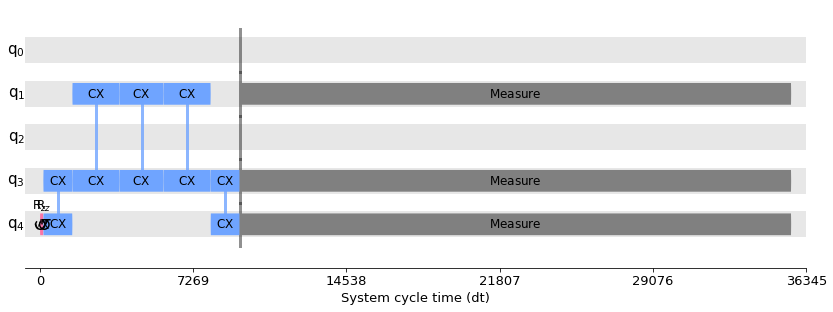

In [4]:
from qiskit import QuantumCircuit, transpile
from qiskit.test import mock

# Simulator backend
target_backend = mock.FakeVigo()
backend = DelayAerSimulator.from_backend(target_backend,
                                         noise_model=None,
#                                          delay_noise=False,
                                        )
properties = backend.properties()

#Make a cirucit
##opt1: simple GHZ state
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.cx(0, 2)
qc.measure_all()
##opt2: complicated mess
# qc = QuantumCircuit(4)
# qc.h(0)
# qc.cx(0, 1)
# qc.x(1)
# qc.cx(0, 2)
# qc.x(2)
# qc.cz(1, 0)
# qc.h(1)
# qc.cx(1, 3)
# qc.measure_all()

# Schedule
sched_circ = transpile(qc, backend, scheduling_method='alap')
draw(sched_circ)

In [5]:
sched_circ.draw(fold=-1)

┌─────────────────┐                                                                       ░ ┌──────────────────┐      
ancilla_0 -> 0 ┤ DELAY(9472[dt]) ├───────────────────────────────────────────────────────────────────────░─┤ DELAY(26160[dt]) ├──────
               ├─────────────────┤                                         ┌───┐     ┌─────────────────┐ ░ └──────────────────┘┌─┐   
      q_2 -> 1 ┤ DELAY(1536[dt]) ├───────────────────────────────■─────────┤ X ├──■──┤ DELAY(1376[dt]) ├─░─────────────────────┤M├───
               ├─────────────────┤                               │         └─┬─┘  │  └─────────────────┘ ░ ┌──────────────────┐└╥┘   
ancilla_1 -> 2 ┤ DELAY(9472[dt]) ├───────────────────────────────┼───────────┼────┼──────────────────────░─┤ DELAY(26160[dt]) ├─╫────
               └┬────────────────┤                 ┌───┐       ┌─┴─┐         │  ┌─┴─┐       ┌───┐        ░ └──────────────────┘ ║ ┌─┐
      q_1 -> 3 ─┤ DELAY(160[dt]) ├─────────────────┤ X ├───────┤ X ├─────────■──┤ X ├───────┤ X ├────────░──────────────────────╫─┤M├
                └──┬─────────┬───┘┌────┐┌─────────┐└─┬─┘┌──────┴───┴──────┐     └───┘       └─┬─┘        ░         ┌─┐          ║ └╥┘
      q_0 -> 4 ────┤ RZ(π/2) ├────┤ √X ├┤ RZ(π/2) ├──■──┤ DELAY(6560[dt]) ├───────────────────■──────────░─────────┤M├──────────╫──╫─
                   └─────────┘    └────┘└─────────┘     └─────────────────┘                              ░         └╥┘          ║  ║ 
       meas: 3/═════════════════════════════════════════════════════════════════════════════════════════════════════╩═══════════╩══╩═
                                                                                                                    0           1  2

In [6]:
# Run using custom backend
result = backend.run([sched_circ]).result()
##Note: if the circuit is sufficiently complicated, you should see a majority of correct counts
## plus a few scattered incorrect (error) counts
result.get_counts(0)

{'010': 13, '101': 2, '000': 485, '111': 524}

## Example 2a: Running the T1 Experiment with a normal backend

In [7]:
import numpy as np
from qiskit_experiments.library import T1

In [8]:
# Check backend recorded T1 of qubit-0 (this should be in 's' units)
t1_qubit0 = properties.t1(0)
t1_qubit0

0.00012170801410836628

Adding a job from a backend (qasm_simulator) that is different than the current backend (fake_vigo). The new backend will be used, but service is not changed if one already exists.


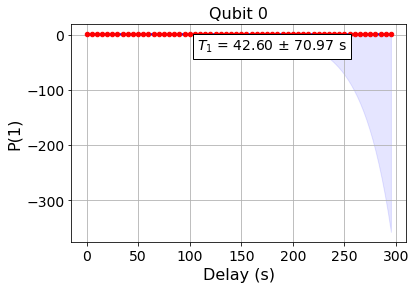

DbAnalysisResultV1
- name: T1
- value: 42.59923795037315 ± 70.97481706754223 s
- χ²: 1.3125800006936292
- quality: bad
- extra: <9 items>
- device_components: ['Q0']
- verified: False


In [9]:
delays = list(range(0, 300, 5))

# T1 Experiment on a typical backend
_t1exp = T1(qubit=0, delays=delays, unit='s')
_t1data = _t1exp.run(backend=FakeVigo(), shots=1000).block_for_results()

# Print analysis results
display(_t1data.figure(0))
_t1result = _t1data.analysis_results(-1)
print(_t1result)

## Example 2.b: Running a T1 experiment

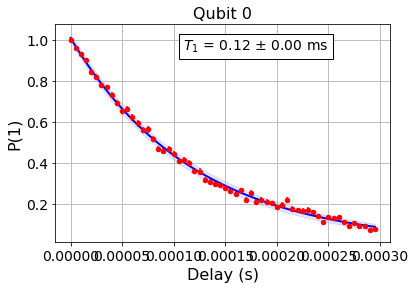

DbAnalysisResultV1
- name: T1
- value: 0.00011876720341347374 ± 3.0646711610124463e-06 s
- χ²: 0.00021708459241537347
- quality: good
- extra: <9 items>
- device_components: ['Q0']
- verified: False


In [10]:
# T1 experiment on qubit 0
t1exp = T1(qubit=0, delays=delays, unit='us')

# Run on the delay-noise backend
t1data = t1exp.run(backend=backend, shots=1000).block_for_results()

# Print analysis results
#   NOTE: if delay noise is correct this should show a plot of exponential decay
#   and fit a value close to the `t1_qubit0` target
display(t1data.figure(0))
t1result = t1data.analysis_results(-1)
print(t1result)

In [11]:
t1_qubit0

0.00012170801410836628